# Plotting shapefiles and geospatial data in Python 3.5 with Geopandas and Basemap

### (on OS X and Anaconda + Python 3.5)

In this tutorial, I cover how to install geopandas for OSX and Python 3.5 (using Anaconda), and then how to read (and reproject) shapefile data into a [geopandas.GeoDataFrame](http://geopandas.org/user.html#geodataframe) and then plot it using [Basemap](http://matplotlib.org/basemap/index.html). This gets you fairly close to the programmatic geospatial-data-charting that's a bit easier to come by in [R's ggplot2 and rgdal](http://zevross.com/blog/2014/07/16/mapping-in-r-using-the-ggplot2-package/).

[Geopandas](http://geopandas.org/) brings a lot of geospatial functionality to the pandas DataFrame, including coordinate system projection and GIS queries akin to PostGIS, so you can think of geopandas as Python's equivalent to the R's [rgdal package](https://cran.r-project.org/web/packages/rgdal/index.html). Geopandas is actually a wrapper for a suite of useful libraries, such as [fiona](https://github.com/Toblerity/Fiona) for shapefile handling and [shapely for Cartesian geospatial analysis](http://toblerity.org/shapely/manual.html). 

It's possible to read shapefiles using only Basemap -- I [have an example here](https://github.com/dannguyen/gis-geospatial-fun-python3x/blob/master/plot_census_counties.py) -- but I don't think it handles as wide a variety of formats as fiona allows. Most annoyingly, it can't deal with shapefiles that aren't in [EPSG:4326](http://spatialreference.org/ref/epsg/wgs-84/). I've been unsuccessful in figuring out a graceful way to just open and reproject shapefiles using [GDAL](http://www.gdal.org/), so Fiona fills that need. Of course, geopandas does more than just wrap up fiona, though for the purposes of brevity, I limit the GeoDataFrame and GIS functionality to the minimum needed to just access the geospatial data frame's geometry.



## Data sources

For data,  we'll use: 

- [the San Francisco zip code boundaries](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-ZIP-Codes-Zipped-Shapefile-Format-/hbza-6v77)
- the [Census's county boundary shapefiles](https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html).
- the [USGS Earthquake Archive](http://earthquake.usgs.gov/earthquakes/search/), specifically, all M4.5+ earthquakes in the contiguous United States, from 1990 to end of 2015.

Here's what the final product will be: two shapefile layers with a point data (earthquakes) -

![img quakes](assets/simple-quakes-bay-counties-zips.png)

### Supplementary reading

This tutorial was informed by these tutorials:

- [Three ways to make a choropleth](https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/) by ocefpaf
- [Geodata manipulation with GeoPandas](https://michelleful.github.io/code-blog/2015/04/29/geopandas-manipulation/) by [Michelle Fullwood](https://michelleful.github.io/)
- [Plotting polygon Shapefiles on a Matplotlib Basemap with GeoPandas, Shapely and Descartes](https://borealperspectives.wordpress.com/2016/03/07/plotting-polygon-shapefiles-on-a-matplotlib-basemap-with-geopandas-shapely-and-descartes/) by [Boreal Perspectives](https://borealperspectives.wordpress.com/)
- [How to plot Shapely Points using Matplotlib, Basemap, and Descartes](https://gist.github.com/urschrei/6436526) by [Stephan Hügel](https://github.com/urschrei)
- [Drawing a Map Background](http://matplotlib.org/basemap/users/geography.html) from the Matplotlib basemap tutorial
- [Basemap tutorial](http://basemaptutorial.readthedocs.io/en/latest/) by Roger Veciana.
- [Mapping earthquakes in Python 3.x using matplotlib and matplotlib's basemap](https://gist.github.com/dannguyen/eb1c4e70565d8cb82d63); this is a tutorial I've written covering how to get baseamp installed and how to plot earthquake data. I'll assume you've read it rather than repeat the instructions there regarding how to install basemap.


Special thanks to [Felipe (ocefpaf) for his extensive documentation on Python GIS work](https://ocefpaf.github.io/python4oceanographers/). 


# Installing Geopandas on OSX via Anaconda

This was the hardest step. [Geopandas is relatively young](http://geopandas.org/), and [libgdal](https://pypi.python.org/pypi/GDAL/) seems to generally been complicated to install. Anaconda with its conda package management seems to alleviate most of the problems. The one hiccup that took time to get over was getting one of Geopandas's dependencies, [fiona (a friendlier API for OGR)](https://github.com/Toblerity/Fiona) to work with the rest of geopandas's parts.

The main issue, as of May 2016 with Anaconda 2.5+ and Python 3.5.1, seems to be that Anaconda's manager will bring in __libgdal v. 2.0__, but [fiona is not yet compatible with 2.0](https://github.com/ioos/conda-recipes/issues/623#issuecomment-161003390).

So to install geopandas with the `conda` installer, specify that libgdal needs to be _less than_ 2.0. The command below also calls in from the [conda-forge channel](https://github.com/conda-forge/geopandas-feedstock)

```sh
conda install -c conda-forge geopandas "libgdal<2.0" 
```

These are the relevant packages I ended up with:

```
geopandas                 0.1.1                    py35_2    conda-forge
fiona                     1.6.4               np110py35_1    conda-forge
libgdal                   1.11.2                        2    defaults
```




# Download the data

Run the following step once to get the files bootstraped to the local directory

In [242]:
import requests
from pathlib import Path
DATA_PATH = Path('notebookdata')
DATA_PATH.mkdir(exist_ok=True)
# https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-ZIP-Codes-Zipped-Shapefile-Format-/hbza-6v77
BAYAREA_ZIP_URL = 'http://apps.sfgov.org/datafiles/view.php?file=sfgis/bayarea_zipcodes.zip'
BAYAREA_ZIP_PATH = DATA_PATH.joinpath('bayarea_zipcodes.zip')
# https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html
CENSUS_COUNTIES_ZIP_PATH = DATA_PATH.joinpath('cb_2015_us_county_5m.zip')
CENSUS_COUNTIES_ZIP_URL = 'http://www2.census.gov/geo/tiger/GENZ2015/shp/cb_2015_us_county_5m.zip'
# http://earthquake.usgs.gov/earthquakes/search/
QUAKES_PARAMS = {'starttime': '1990-01-01 00:00:00', 'endtime': '2015-12-31 23:59:59',                 
                 'minlatitude': 24.6, 'maxlatitude': 50, 'minlongitude':-125, 'maxlongitude': -65,
                 'minmagnitude': 4.5, 'eventtype': 'earthquake', 'orderby': 'time'}                             
QUAKES_ENDPOINT = 'http://earthquake.usgs.gov/fdsnws/event/1/query.geojson'
QUAKES_PATH = DATA_PATH.joinpath('us_quakes_1990_2015_M4.5.json')
# Download and save the files
BAYAREA_ZIP_PATH.write_bytes(requests.get(BAYAREA_ZIP_URL).content)
CENSUS_COUNTIES_ZIP_PATH.write_bytes(requests.get(CENSUS_COUNTIES_ZIP_URL).content)
QUAKES_PATH.write_text(requests.get(QUAKES_ENDPOINT, params=QUAKES_PARAMS).text)


590975

## Reading shapefiles into GeoDataFrames

Note that with fiona, we don't have to unzip the shapefile; [fiona can read the zip file as a virtual file system](http://toblerity.org/fiona/manual.html#virtual-filesystems).

In [243]:
import geopandas as gpd
# bay area zips
bdf = gpd.read_file('zip://' + str(BAYAREA_ZIP_PATH));
# counties
cdf = gpd.read_file('zip://' + str(CENSUS_COUNTIES_ZIP_PATH))
# quakes
qdf = gpd.read_file(str(QUAKES_PATH))

## Plotting a GeoDataFrame

Like the pandas.DataFrame, geopandas.GeoDataFrame comes with a `plot()` function for easy plotting, though it's not very flexible:

In [239]:
# only required for ipython notebook
%matplotlib inline

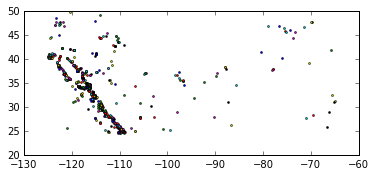

In [240]:
# earthquakes (will take a bit of time to plot)
qdf.plot();

The Bay Area zip code data comes with a non-lat-long projection. Here's what it looks like when plotted (note the axes):

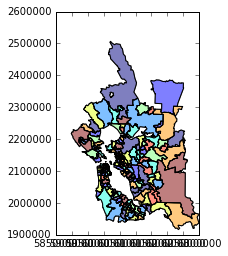

In [155]:
bdf.plot();

## Using GeoDataFrame.to_crs() to reproject coordinate systems

GeoDataFrames have a [nice convenience method, to_crs(), that can take a EPSG number as an argument](http://geopandas.org/user.html#GeoSeries.to_crs). This is handy because the Matplotlib Basemap library will not work with non-lat/long coordinate systems.

To convert the Bay Area zip code shapedata into latitude/longitude, [i.e. EPSG:4326](http://spatialreference.org/ref/epsg/wgs-84/)

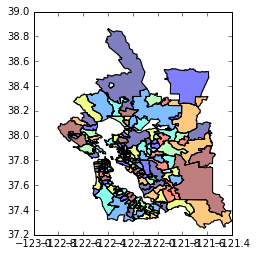

In [244]:
baydf = bdf.to_crs(epsg='4326')
# note the different axes
baydf.plot();

Projecting the counties data will require drawing the entire world, basically, since Alaska goes across the international dateline:

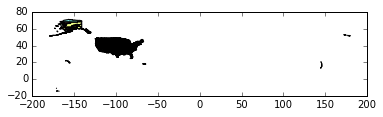

In [115]:
# counties map
cdf.plot();

## Making plottable geometries

So we'll need something more flexible than the GeoDataFrame.plot() method if we want to chart more than one geospatial dataset. So we'll use [Matplotlib's Basemap library](http://matplotlib.org/basemap/users/geography.html), which will also allow us to customize the viewport (i.e. only show Bay Area counties).

However, we need to convert the geometries in GeoDataFrames into a format that can be added to a Matplotlib axis. From the tutorials I've looked at, one common practice seems to be iterating through the GeoDataFrame's `geometry` attribute, converting each `Polygon` (or `MultiPolygon`) into a `descartes.PolygonPatch`, and then appending it to a list which is converted to a `matplotlib.collections.PatchCollection`.

I've written a simple implementation as a function named `geometry_to_polygons`, with keyword arguments being passed directly into the `PolygonPatch()` constructor (which allows customization of the appearance of each shape).


In [216]:
from matplotlib.collections import PatchCollection
from shapely.geometry import Point, MultiPolygon
from descartes import PolygonPatch

def geometry_to_polygons(df, **kwargs):
    polys = []
    for g in df.geometry:
        if g.geom_type == 'Polygon':
            polys.append(PolygonPatch(g, **kwargs))
        elif g.geom_type == 'MultiPolygon':
            for h in g:
                polys.append(PolygonPatch(h, **kwargs))
    return PatchCollection(polys, match_original=True)

Here's the code to plot the geometries/polygons to a matplotlib axis; the Census county boundaries are plotted first, with green boundaries and light green shading. The zip code boundaries are plotted on top with gray boundaries and `"none"` for `fc` (i.e. `facecolor`). Because the Census county shapedata is at lower resolution than the zip code shapedata, the boundaries don't quite line up:

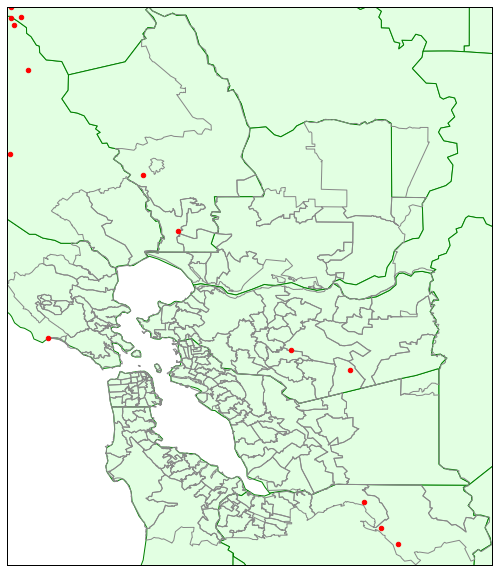

In [241]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(10,10))
bmap = Basemap(ax=ax, 
               llcrnrlon=lng0, urcrnrlon=lng1, 
               llcrnrlat=lat0, urcrnrlat=lat1)
bmap.drawstates()
ax.add_collection(geometry_to_polygons(cdf, ec='green', fc='#E2FFE2'));            
ax.add_collection(geometry_to_polygons(baydf, ec='#888888', fc='none'))
# points have to be added via scatter
qpts = [Point(q) for q in qdf.geometry]
ax.scatter([q.x for q in qpts], [q.y for q in qpts], color="red")

# Conclusion

That covers the scope of this tutorial, which is just how to use the __geopandas__ suite to read data and pass it to Matplotlib. Note that we didn't do _any_ geospatial analysis...for example, we technically plotted all of the earthquake data points...but we only see the Bay Area earthquakes because we've restricted the viewport to the bounding box of the Bay Area zip codes. Check out the tutorials listed at the top of this tutorial, or the [geopandas homepage itself](http://geopandas.org/), for details on how to manipulate GeoDataFrames with GIS calculations.